# Unit13_CatBoost | 分類任務：化工設備多類別故障診斷（進階）

本 Notebook 展示如何使用 **CatBoost** 處理極度不平衡的多類別分類問題（7類）。

## 情境說明
某化工廠擁有大量關鍵設備，需要建立智能故障診斷系統。系統收集了 **150,000 筆設備運行數據**，包含：
- **15 個傳感器數據**：溫度（4）、壓力（3）、流量（3）、振動（3）、聲音（1）、電流（1）
- **8 個設備參數**：運行時間、啟停次數、維護間隔、設備年齡、型號、操作員、班次、負載率
- **7 個衍生特徵**：溫差、壓降比、振動幅度、時間特徵、健康指數、異常計數

### 目標
建立多類別分類模型，預測設備的 7 種狀態：
0. 正常運行 (70%)
1. 輕微磨損 (15%)
2. 溫度異常 (5%)
3. 壓力波動 (4%)
4. 泄漏警告 (3%)
5. 嚴重故障 (2%)
6. 緊急停機 (1%)

**資料特性：極度不平衡** - 緊急停機僅佔 1%！

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit13_CatBoost_Classification'
SOURCE_DATA_DIR = 'no_data_folder'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit13'
    DATA_DIR = shortcut_path / 'Part_3' / 'data' / SOURCE_DATA_DIR
    OUTPUT_DIR = shortcut_path / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
    print(f"✓ Colab 路徑設定完成")
  else:
    raise FileNotFoundError("請確認 Google Drive 中有 'Colab Notebooks/CHE-AI-COURSE' 資料夾")
else:
  NOTEBOOK_DIR = Path.cwd()
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'
  print(f"✓ Local 路徑設定完成")

# 建立輸出資料夾
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n📁 工作目錄: {NOTEBOOK_DIR}")
print(f"📁 輸出目錄: {OUTPUT_DIR}")
print(f"📁 模型目錄: {MODEL_DIR}")
print(f"📁 圖片目錄: {FIG_DIR}")

✓ 偵測到 Local 環境
✓ Local 路徑設定完成

📁 工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13
📁 輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Classification
📁 模型目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Classification\models
📁 圖片目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Classification\figs


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# CatBoost
from catboost import CatBoostClassifier, Pool

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# 模型儲存
import joblib, json

# 設定隨機種子
SEED = 42
np.random.seed(SEED)

# 設定matplotlib顯示
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

print(f"✓ NumPy version: {np.__version__}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ 套件載入完成")

✓ NumPy version: 1.23.5
✓ Pandas version: 2.3.3
✓ 套件載入完成


---
## 2. 生成大規模不平衡數據（150,000 筆）

In [3]:
print("開始生成大規模不平衡數據...")
start_time = time.time()

# 設定資料數量與類別分布（極度不平衡）
n_samples = 150000
class_distribution = {
    0: 0.70,  # 正常運行
    1: 0.15,  # 輕微磨損
    2: 0.05,  # 溫度異常
    3: 0.04,  # 壓力波動
    4: 0.03,  # 泄漏警告
    5: 0.02,  # 嚴重故障
    6: 0.01   # 緊急停機
}

# 生成類別標籤
np.random.seed(SEED)
fault_type = np.random.choice(
    list(class_distribution.keys()),
    size=n_samples,
    p=list(class_distribution.values())
)

# 生成時間序列索引
start_date = datetime(2023, 1, 1)
timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]

print(f"✓ 類別標籤生成完成 (7個類別)")
print(f"\n類別分布:")
for cls, count in zip(*np.unique(fault_type, return_counts=True)):
    class_names = ['正常運行', '輕微磨損', '溫度異常', '壓力波動', 
                   '泄漏警告', '嚴重故障', '緊急停機']
    pct = count / n_samples * 100
    print(f"  Class {cls} ({class_names[cls]}): {count:,} ({pct:.2f}%)")

# ========================================
# 傳感器數據（15個）- 根據故障類型調整分布
# ========================================

# 基礎溫度（正常時的分布）
temp_inlet_base = np.random.normal(80, 10, n_samples)
temp_outlet_base = np.random.normal(120, 15, n_samples)
temp_wall_base = np.random.normal(100, 12, n_samples)
temp_ambient_base = 20 + 10 * np.sin(np.arange(n_samples) * 2 * np.pi / (365 * 24)) + np.random.normal(0, 3, n_samples)

# 根據故障類型調整溫度
temp_inlet = temp_inlet_base.copy()
temp_outlet = temp_outlet_base.copy()
temp_wall = temp_wall_base.copy()

# 溫度異常 (class 2)
temp_inlet[fault_type == 2] += np.random.uniform(20, 50, np.sum(fault_type == 2))
temp_outlet[fault_type == 2] += np.random.uniform(30, 60, np.sum(fault_type == 2))

# 嚴重故障/緊急停機
for cls in [5, 6]:
    temp_wall[fault_type == cls] += np.random.uniform(40, 80, np.sum(fault_type == cls))

# 壓力數據
pressure_inlet_base = np.random.normal(5.0, 0.5, n_samples)
pressure_outlet_base = np.random.normal(1.5, 0.3, n_samples)
pressure_diff_base = pressure_inlet_base - pressure_outlet_base

pressure_inlet = pressure_inlet_base.copy()
pressure_outlet = pressure_outlet_base.copy()

# 壓力波動 (class 3)
pressure_inlet[fault_type == 3] += np.random.uniform(-2, 2, np.sum(fault_type == 3))
pressure_outlet[fault_type == 3] += np.random.uniform(-1, 1, np.sum(fault_type == 3))

pressure_diff = pressure_inlet - pressure_outlet

# 流量數據
flow_inlet = np.random.uniform(80, 150, n_samples)
flow_product = np.random.uniform(60, 120, n_samples)
flow_recycle = np.random.uniform(20, 60, n_samples)

# 泄漏警告 (class 4)
flow_product[fault_type == 4] -= np.random.uniform(20, 40, np.sum(fault_type == 4))

# 振動數據（正常時較小）
vibration_x_base = np.random.exponential(2, n_samples)
vibration_y_base = np.random.exponential(2, n_samples)
vibration_z_base = np.random.exponential(2, n_samples)

vibration_x = vibration_x_base.copy()
vibration_y = vibration_y_base.copy()
vibration_z = vibration_z_base.copy()

# 輕微磨損增加振動 (class 1)
for cls in [1, 5, 6]:
    multiplier = 2 if cls == 1 else 4
    vibration_x[fault_type == cls] *= np.random.uniform(multiplier, multiplier+1, np.sum(fault_type == cls))
    vibration_y[fault_type == cls] *= np.random.uniform(multiplier, multiplier+1, np.sum(fault_type == cls))
    vibration_z[fault_type == cls] *= np.random.uniform(multiplier, multiplier+1, np.sum(fault_type == cls))

# 聲音與電流
noise_level = np.random.uniform(60, 80, n_samples)
noise_level[fault_type >= 5] += np.random.uniform(20, 40, np.sum(fault_type >= 5))

current_consumption = np.random.uniform(100, 200, n_samples)
current_consumption[fault_type >= 4] += np.random.uniform(50, 100, np.sum(fault_type >= 4))

print(f"✓ 傳感器數據生成完成 (15個)")

# ========================================
# 設備參數（8個）
# ========================================

# 運行時間（累計）
operating_hours = np.cumsum(np.random.uniform(0.9, 1.1, n_samples))

# 啟停次數（故障時更多）
start_stop_count = np.random.poisson(2, n_samples)
start_stop_count[fault_type >= 4] += np.random.poisson(3, np.sum(fault_type >= 4))

# 維護間隔
days_since_maintenance = np.random.uniform(0, 180, n_samples)
days_since_maintenance[fault_type >= 3] += np.random.uniform(90, 180, np.sum(fault_type >= 3))

# 設備年齡
equipment_age = np.random.uniform(0, 15, n_samples)

# 設備型號（類別）
equipment_model = np.random.choice(['A', 'B', 'C'], n_samples, p=[0.5, 0.3, 0.2])

# 操作員（類別）
operator_id = np.random.choice(range(1, 11), n_samples)

# 班次（類別）
shift = np.random.choice([1, 2, 3], n_samples, p=[0.4, 0.35, 0.25])

# 負載率
load_factor = np.random.uniform(0.5, 1.0, n_samples)
load_factor[fault_type >= 4] = np.random.uniform(0.7, 1.0, np.sum(fault_type >= 4))

print(f"✓ 設備參數生成完成 (8個)")

# ========================================
# 衍生特徵（7個）
# ========================================

# 溫差
temp_diff_io = temp_outlet - temp_inlet  # 入出口溫差
temp_diff_ambient = temp_wall - temp_ambient_base  # 壁面與環境溫差

# 壓降比例
pressure_drop_ratio = pressure_diff / pressure_inlet

# 振動幅度（總和）
vibration_magnitude = np.sqrt(vibration_x**2 + vibration_y**2 + vibration_z**2)

# 時間特徵
hour_of_day = np.array([ts.hour for ts in timestamps])

# 設備健康指數（綜合指標，0-100）
health_index = 100 - (
    0.3 * (vibration_magnitude / vibration_magnitude.mean()) * 10 +
    0.2 * (days_since_maintenance / 180) * 100 +
    0.2 * (equipment_age / 15) * 100 +
    0.3 * (start_stop_count / start_stop_count.mean()) * 10
)
health_index = np.clip(health_index, 0, 100)

# 異常計數（過去24小時的異常指標數量）
abnormal_count = np.zeros(n_samples, dtype=int)
abnormal_count[temp_inlet > 110] += 1
abnormal_count[vibration_magnitude > 5] += 1
abnormal_count[pressure_diff < 2] += 1
abnormal_count[fault_type >= 2] += np.random.poisson(2, np.sum(fault_type >= 2))

print(f"✓ 衍生特徵生成完成 (7個)")

# ========================================
# 建立 DataFrame
# ========================================
df = pd.DataFrame({
    # 時間索引
    'Timestamp': timestamps,
    
    # 傳感器數據（15個）
    'Temp_Inlet': temp_inlet,
    'Temp_Outlet': temp_outlet,
    'Temp_Wall': temp_wall,
    'Temp_Ambient': temp_ambient_base,
    'Pressure_Inlet': pressure_inlet,
    'Pressure_Outlet': pressure_outlet,
    'Pressure_Diff': pressure_diff,
    'Flow_Inlet': flow_inlet,
    'Flow_Product': flow_product,
    'Flow_Recycle': flow_recycle,
    'Vibration_X': vibration_x,
    'Vibration_Y': vibration_y,
    'Vibration_Z': vibration_z,
    'Noise_Level': noise_level,
    'Current': current_consumption,
    
    # 設備參數（8個）
    'Operating_Hours': operating_hours,
    'Start_Stop_Count': start_stop_count,
    'Days_Since_Maintenance': days_since_maintenance,
    'Equipment_Age': equipment_age,
    'Equipment_Model': equipment_model,
    'Operator_ID': operator_id,
    'Shift': shift,
    'Load_Factor': load_factor,
    
    # 衍生特徵（7個）
    'Temp_Diff_IO': temp_diff_io,
    'Temp_Diff_Ambient': temp_diff_ambient,
    'Pressure_Drop_Ratio': pressure_drop_ratio,
    'Vibration_Magnitude': vibration_magnitude,
    'Hour_of_Day': hour_of_day,
    'Health_Index': health_index,
    'Abnormal_Count': abnormal_count,
    
    # 目標變數
    'Fault_Type': fault_type
})

elapsed_time = time.time() - start_time
print(f"\n✓ 生成 {n_samples:,} 筆資料完成 (耗時: {elapsed_time:.2f}秒)")
print(f"✓ 總特徵數: {df.shape[1] - 2} (不含 Timestamp 和 Target)")
print(f"\n資料預覽:")
print(df.head())

開始生成大規模不平衡數據...
✓ 類別標籤生成完成 (7個類別)

類別分布:
  Class 0 (正常運行): 104,965 (69.98%)
  Class 1 (輕微磨損): 22,545 (15.03%)
  Class 2 (溫度異常): 7,648 (5.10%)
  Class 3 (壓力波動): 5,958 (3.97%)
  Class 4 (泄漏警告): 4,444 (2.96%)
  Class 5 (嚴重故障): 2,961 (1.97%)
  Class 6 (緊急停機): 1,479 (0.99%)
✓ 傳感器數據生成完成 (15個)
✓ 設備參數生成完成 (8個)
✓ 衍生特徵生成完成 (7個)

✓ 生成 150,000 筆資料完成 (耗時: 0.40秒)
✓ 總特徵數: 30 (不含 Timestamp 和 Target)

資料預覽:
            Timestamp  Temp_Inlet  Temp_Outlet   Temp_Wall  Temp_Ambient  \
0 2023-01-01 00:00:00   81.404695   117.589851   71.866817     23.472821   
1 2023-01-01 01:00:00   72.938747   113.166401   89.482924     17.203657   
2 2023-01-01 02:00:00   86.292986   128.830997  102.120219     22.624153   
3 2023-01-01 03:00:00   87.111411   142.817206   77.998738     16.946817   
4 2023-01-01 04:00:00   50.134998   118.033107  100.728683     18.461558   

   Pressure_Inlet  Pressure_Outlet  Pressure_Diff  Flow_Inlet  Flow_Product  \
0        4.388373         1.974312       2.414060   83.360028     72.3

---
## 3. 加入缺失值（5%）

In [4]:
# 資料統計摘要
print("\n" + "="*60)
print("資料統計摘要")
print("="*60)
print(df.describe())

print("\n" + "="*60)
print("類別分布詳細統計")
print("="*60)
class_names = ['正常運行', '輕微磨損', '溫度異常', '壓力波動', 
               '泄漏警告', '嚴重故障', '緊急停機']
class_stats = df['Fault_Type'].value_counts().sort_index()
for cls, count in class_stats.items():
    pct = count / len(df) * 100
    print(f"  {cls}: {class_names[cls]:12s} - {count:6,} ({pct:5.2f}%)")


資料統計摘要
                 Timestamp     Temp_Inlet    Temp_Outlet      Temp_Wall  \
count               150000  150000.000000  150000.000000  150000.000000   
mean   2031-07-22 23:30:00      81.768410     122.273994     101.744346   
min    2023-01-01 00:00:00      35.861140      55.305406      42.046768   
25%    2027-04-12 11:45:00      73.647241     110.444625      92.106389   
50%    2031-07-22 23:30:00      80.658515     120.984468     100.388422   
75%    2035-11-01 11:15:00      88.025041     132.024979     108.996651   
max    2040-02-10 23:00:00     161.018912     220.686322     216.501263   
std                    NaN      12.772309      18.086713      15.909846   

        Temp_Ambient  Pressure_Inlet  Pressure_Outlet  Pressure_Diff  \
count  150000.000000   150000.000000    150000.000000  150000.000000   
mean       20.032691        4.999648         1.497849       3.501799   
min        -1.665559        1.605433        -0.327842      -0.546990   
25%        13.422382        

---
## 4. 探索性數據分析 (EDA)

In [5]:
# 隨機加入 5% 缺失值（模擬真實情境）
np.random.seed(SEED)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Fault_Type')

missing_ratio = 0.05
for col in numerical_cols[:10]:  # 只在部分欄位加入缺失值
    missing_mask = np.random.random(len(df)) < missing_ratio
    df.loc[missing_mask, col] = np.nan

missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

print("缺失值分布:")
if len(missing_counts) > 0:
    for col, count in missing_counts.items():
        pct = count / len(df) * 100
        print(f"  {col:25s}: {count:6,} ({pct:.2f}%)")
else:
    print("  無缺失值")

print(f"\n✓ 缺失值注入完成")

缺失值分布:
  Temp_Inlet               :  7,391 (4.93%)
  Temp_Outlet              :  7,373 (4.92%)
  Temp_Wall                :  7,577 (5.05%)
  Temp_Ambient             :  7,401 (4.93%)
  Pressure_Inlet           :  7,413 (4.94%)
  Pressure_Outlet          :  7,451 (4.97%)
  Pressure_Diff            :  7,481 (4.99%)
  Flow_Inlet               :  7,333 (4.89%)
  Flow_Product             :  7,507 (5.00%)
  Flow_Recycle             :  7,638 (5.09%)

✓ 缺失值注入完成


### 4.1 類別分布視覺化

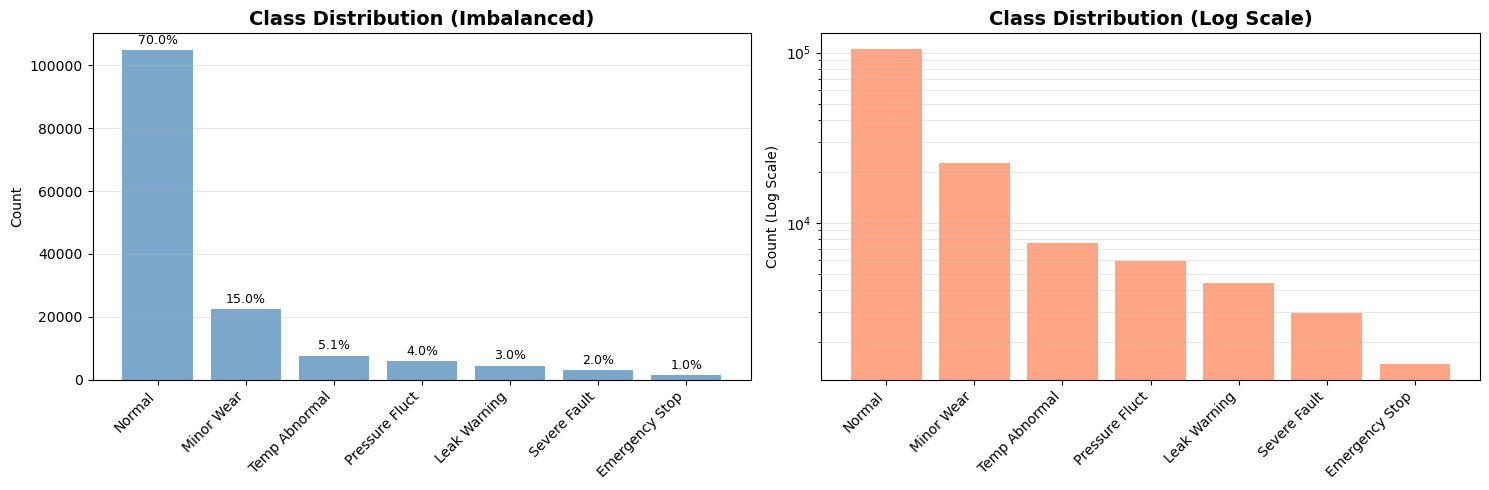

最多類別 (Class 0): 104,965 筆
最少類別 (Class 6): 1,479 筆
不平衡比例: 71.0 : 1


In [6]:
# 類別分布視覺化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 柱狀圖
class_counts = df['Fault_Type'].value_counts().sort_index()
class_labels = ['Normal', 'Minor Wear', 'Temp Abnormal', 'Pressure Fluct', 
                'Leak Warning', 'Severe Fault', 'Emergency Stop']
axes[0].bar(range(len(class_counts)), class_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(class_counts)))
axes[0].set_xticklabels(class_labels, rotation=45, ha='right')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Imbalanced)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i, (cls, count) in enumerate(class_counts.items()):
    pct = count / len(df) * 100
    axes[0].text(i, count + 1000, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

# 對數尺度柱狀圖（更清楚顯示少數類別）
axes[1].bar(range(len(class_counts)), class_counts.values, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(class_counts)))
axes[1].set_xticklabels(class_labels, rotation=45, ha='right')
axes[1].set_ylabel('Count (Log Scale)')
axes[1].set_yscale('log')
axes[1].set_title('Class Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(FIG_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"最多類別 (Class 0): {class_counts[0]:,} 筆")
print(f"最少類別 (Class 6): {class_counts[6]:,} 筆")
print(f"不平衡比例: {class_counts[0] / class_counts[6]:.1f} : 1")

---
## 5. 數據準備

In [7]:
# ========================================
# 定義特徵與目標變數
# ========================================
X = df.drop(columns=['Timestamp', 'Fault_Type'])
y = df['Fault_Type']

print(f"特徵矩陣形狀: {X.shape}")
print(f"目標變數形狀: {y.shape}")

# 識別類別特徵（CatBoost 會自動處理）
cat_features = ['Equipment_Model', 'Operator_ID', 'Shift']
print(f"\n類別特徵: {cat_features}")

# 獲取類別特徵的索引位置
cat_features_indices = [X.columns.get_loc(col) for col in cat_features]
print(f"類別特徵索引: {cat_features_indices}")

print(f"\n特徵數量: {X.shape[1]}")

# ========================================
# 切分資料集：60% 訓練 / 20% 驗證 / 20% 測試
# ========================================
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=SEED, stratify=y_temp
)

print(f"\n✓ 資料切分完成 (使用 stratify 保持類別比例)")
print(f"  訓練集: {X_train.shape[0]:,} 筆 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  驗證集: {X_val.shape[0]:,} 筆 ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  測試集: {X_test.shape[0]:,} 筆 ({X_test.shape[0]/len(X)*100:.1f}%)")

特徵矩陣形狀: (150000, 30)
目標變數形狀: (150000,)

類別特徵: ['Equipment_Model', 'Operator_ID', 'Shift']
類別特徵索引: [19, 20, 21]

特徵數量: 30

✓ 資料切分完成 (使用 stratify 保持類別比例)
  訓練集: 90,000 筆 (60.0%)
  驗證集: 30,000 筆 (20.0%)
  測試集: 30,000 筆 (20.0%)


---
## 6. 建立 CatBoost 分類模型

In [8]:
print("開始訓練 CatBoost 多類別分類模型...")
start_time = time.time()

# 建立 CatBoost 分類模型
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_seed=SEED,
    verbose=100,
    cat_features=cat_features_indices,  # 指定類別特徵索引
    auto_class_weights='Balanced',  # 自動平衡類別權重（處理不平衡問題）
    task_type='GPU',
)

# 訓練模型（使用驗證集進行早停）
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=100,
    plot=False
)

train_time = time.time() - start_time

print(f"\n✓ 模型訓練完成 (耗時: {train_time:.2f}秒)")
print(f"✓ 最佳迭代次數: {model.get_best_iteration()}")
print(f"✓ 最佳驗證集 MultiClass: {model.get_best_score()['validation']['MultiClass']:.4f}")

開始訓練 CatBoost 多類別分類模型...
0:	learn: 1.7746757	test: 1.7757950	best: 1.7757950 (0)	total: 25.7ms	remaining: 25.7s
100:	learn: 0.4189384	test: 0.4397726	best: 0.4397726 (100)	total: 1.34s	remaining: 12s
200:	learn: 0.3527399	test: 0.4126866	best: 0.4126866 (200)	total: 2.66s	remaining: 10.6s
300:	learn: 0.3141705	test: 0.4039575	best: 0.4039575 (300)	total: 3.98s	remaining: 9.25s
400:	learn: 0.2860757	test: 0.4010939	best: 0.4010542 (385)	total: 5.35s	remaining: 7.99s
bestTest = 0.400962846
bestIteration = 409
Shrink model to first 410 iterations.

✓ 模型訓練完成 (耗時: 7.81秒)
✓ 最佳迭代次數: 409
✓ 最佳驗證集 MultiClass: 0.4010


### 6.1 模型評估

In [9]:
# 訓練集預測
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')

# 驗證集預測
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1_macro = f1_score(y_val, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

# 測試集預測
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# 顯示結果
print("="*60)
print("模型評估結果（多類別分類）")
print("="*60)
print(f"訓練集:")
print(f"  Accuracy:      {train_accuracy:.4f}")
print(f"  F1 (Macro):    {train_f1_macro:.4f}")
print(f"  F1 (Weighted): {train_f1_weighted:.4f}")
print(f"\n驗證集:")
print(f"  Accuracy:      {val_accuracy:.4f}")
print(f"  F1 (Macro):    {val_f1_macro:.4f}")
print(f"  F1 (Weighted): {val_f1_weighted:.4f}")
print(f"\n測試集:")
print(f"  Accuracy:      {test_accuracy:.4f}")
print(f"  F1 (Macro):    {test_f1_macro:.4f}")
print(f"  F1 (Weighted): {test_f1_weighted:.4f}")

# 詳細分類報告（測試集）
print("\n" + "="*60)
print("測試集詳細分類報告")
print("="*60)
class_names_en = ['Normal', 'Minor Wear', 'Temp Abnormal', 'Pressure Fluct', 
                  'Leak Warning', 'Severe Fault', 'Emergency Stop']
print(classification_report(y_test, y_test_pred, target_names=class_names_en, digits=4))

模型評估結果（多類別分類）
訓練集:
  Accuracy:      0.8337
  F1 (Macro):    0.8934
  F1 (Weighted): 0.8437

驗證集:
  Accuracy:      0.8201
  F1 (Macro):    0.7513
  F1 (Weighted): 0.8299

測試集:
  Accuracy:      0.8195
  F1 (Macro):    0.7455
  F1 (Weighted): 0.8290

測試集詳細分類報告
                precision    recall  f1-score   support

        Normal     0.9332    0.8255    0.8760     20993
    Minor Wear     0.4940    0.7257    0.5879      4509
 Temp Abnormal     0.8894    0.9830    0.9339      1530
Pressure Fluct     0.8417    0.9328    0.8849      1191
  Leak Warning     0.9426    0.9606    0.9515       889
  Severe Fault     0.6637    0.7466    0.7027       592
Emergency Stop     0.3274    0.2466    0.2813       296

      accuracy                         0.8195     30000
     macro avg     0.7274    0.7744    0.7455     30000
  weighted avg     0.8503    0.8195    0.8290     30000



### 6.2 混淆矩陣

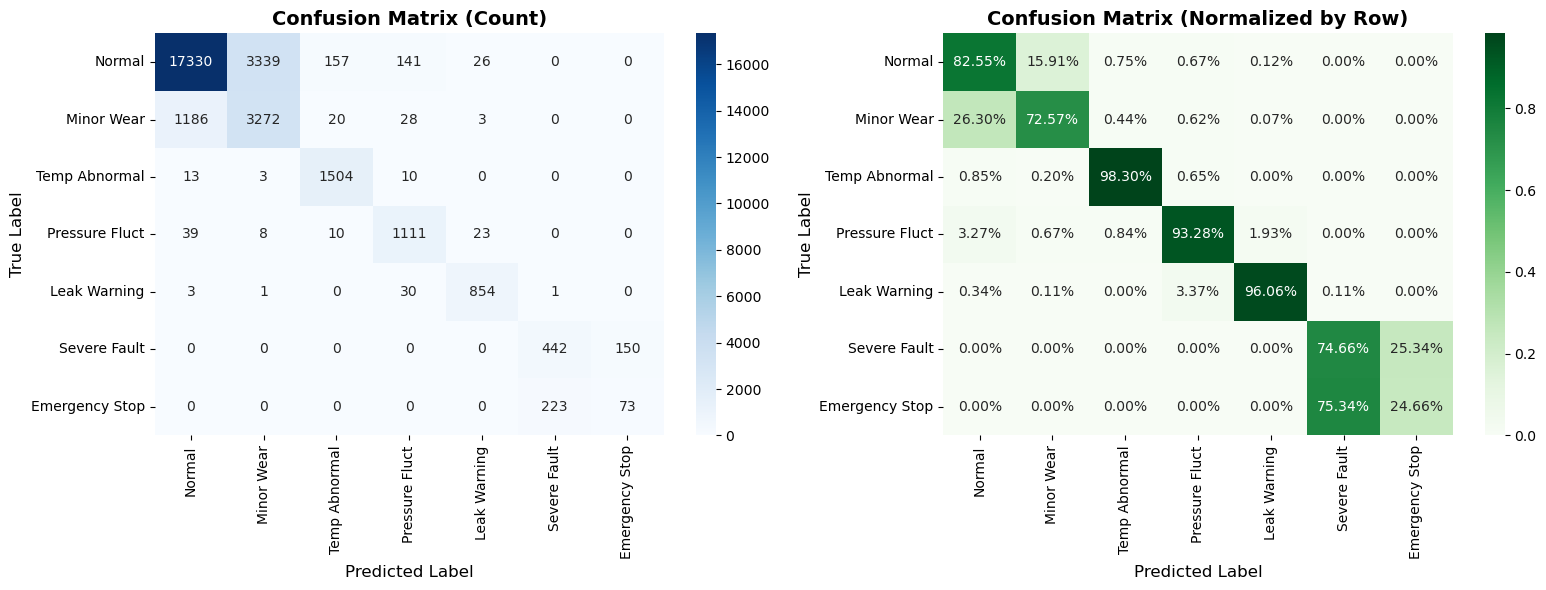


各類別召回率 (Recall):
  Class 0 (Normal         ): 0.8255
  Class 1 (Minor Wear     ): 0.7257
  Class 2 (Temp Abnormal  ): 0.9830
  Class 3 (Pressure Fluct ): 0.9328
  Class 4 (Leak Warning   ): 0.9606
  Class 5 (Severe Fault   ): 0.7466
  Class 6 (Emergency Stop ): 0.2466


In [10]:
# 計算混淆矩陣
cm = confusion_matrix(y_test, y_test_pred)

# 視覺化混淆矩陣
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：絕對數量
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_en, yticklabels=class_names_en, ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix (Count)', fontsize=14, fontweight='bold')

# 右圖：百分比（行標準化）
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=class_names_en, yticklabels=class_names_en, ax=axes[1])
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix (Normalized by Row)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix_catboost.png', dpi=300, bbox_inches='tight')
plt.show()

# 計算每個類別的準確率（對角線元素 / 該類別總數）
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print("\n各類別召回率 (Recall):")
for i, (name, acc) in enumerate(zip(class_names_en, class_accuracies)):
    print(f"  Class {i} ({name:15s}): {acc:.4f}")

### 6.3 各類別性能分析

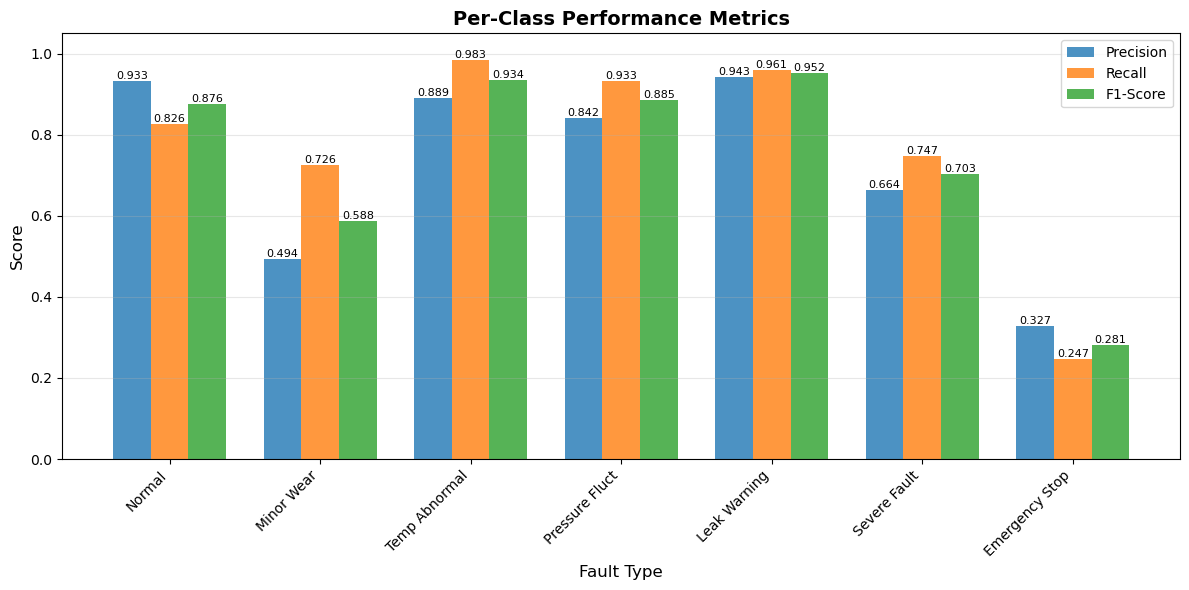

In [11]:
# 計算各類別的 Precision、Recall、F1-Score
precision_per_class = precision_score(y_test, y_test_pred, average=None)
recall_per_class = recall_score(y_test, y_test_pred, average=None)
f1_per_class = f1_score(y_test, y_test_pred, average=None)

# 創建性能比較圖
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(class_names_en))
width = 0.25

bars1 = ax.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Fault Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_en, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# 在柱狀圖上標註數值
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / 'per_class_metrics_catboost.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 7. 特徵重要性分析

Top 15 Feature Importance:
               Feature  Importance
           Noise_Level   21.746276
               Current    7.884756
             Temp_Wall    7.144263
     Temp_Diff_Ambient    6.534490
Days_Since_Maintenance    6.470499
   Vibration_Magnitude    5.806899
        Abnormal_Count    5.243777
            Temp_Inlet    4.608504
          Flow_Product    3.277016
           Temp_Outlet    2.921897
      Start_Stop_Count    2.663209
           Load_Factor    2.308447
           Vibration_X    2.219031
           Vibration_Z    2.079979
           Vibration_Y    2.049941


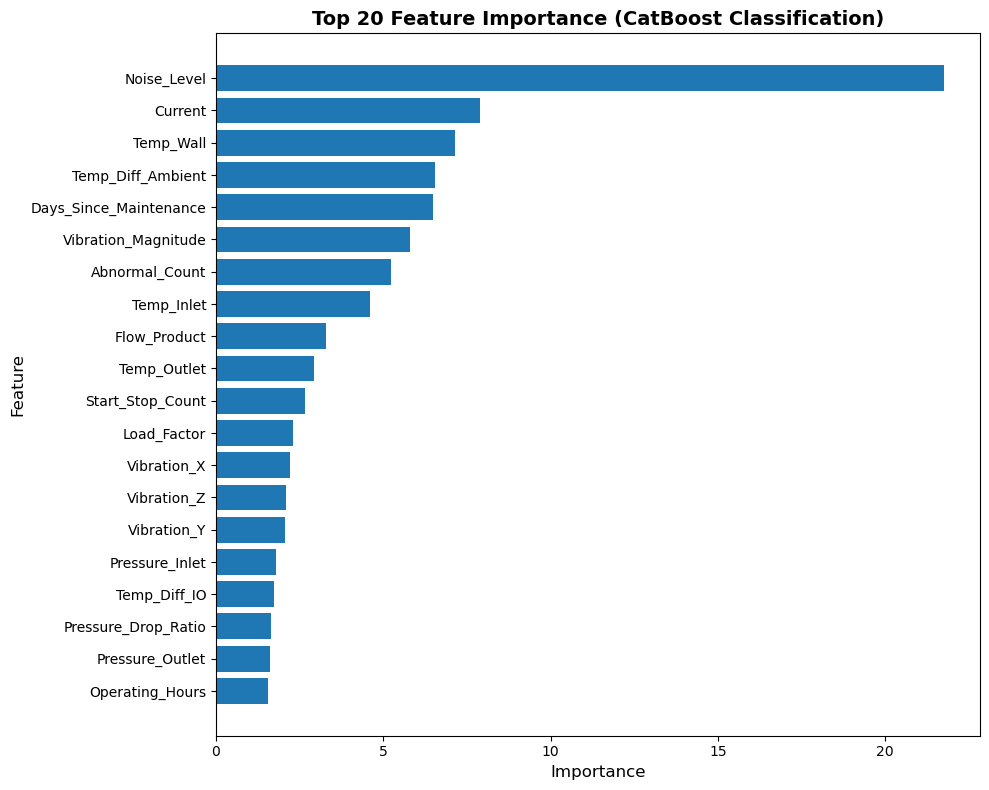

In [12]:
# 獲取特徵重要性
feature_importance = model.get_feature_importance()
feature_names = X.columns

# 創建 DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 15 Feature Importance:")
print(importance_df.head(15).to_string(index=False))

# 視覺化（Top 20）
plt.figure(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)
plt.barh(range(top_n), top_features['Importance'].values)
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance (CatBoost Classification)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance_classification.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 8. 模型保存與載入

---
## 9. 總結

In [13]:
# 保存模型
model_path_cbm = MODEL_DIR / 'catboost_classification.cbm'
model_path_json = MODEL_DIR / 'catboost_classification.json'

model.save_model(str(model_path_cbm))
model.save_model(str(model_path_json), format='json')

print(f"✓ Model saved to:")
print(f"  - {model_path_cbm}")
print(f"  - {model_path_json}")

# 載入模型（示範）
loaded_model = CatBoostClassifier()
loaded_model.load_model(str(model_path_cbm))

# 測試載入的模型
y_test_pred_loaded = loaded_model.predict(X_test)
test_accuracy_loaded = accuracy_score(y_test, y_test_pred_loaded)

print(f"\n✓ Model loaded successfully")
print(f"Test Accuracy (loaded model): {test_accuracy_loaded:.4f}")

✓ Model saved to:
  - d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Classification\models\catboost_classification.cbm
  - d:\MyGit\CHE-AI-COURSE\Part_3\Unit13\outputs\P3_Unit13_CatBoost_Classification\models\catboost_classification.json

✓ Model loaded successfully
Test Accuracy (loaded model): 0.8195


### 本範例展示了：

1. **多類別不平衡分類問題**：
   - 處理 **7 個類別**，分布極度不平衡（70% vs 1%）
   - 使用 `auto_class_weights='Balanced'` 自動平衡類別權重
   - 不平衡比例達到 **70:1**（正常運行 vs 緊急停機）

2. **化工設備多類別故障診斷**：
   - 150,000 筆大規模數據
   - 30 個特徵（15 傳感器 + 8 設備參數 + 7 衍生特徵）
   - 結合數值特徵（溫度、壓力、流量、振動）與類別特徵（設備型號、操作員、班次）

3. **評估指標選擇**：
   - **不能只看 Accuracy**：在不平衡數據中可能誤導
   - **Macro F1-Score**：平等對待每個類別
   - **Weighted F1-Score**：考慮類別樣本數量
   - **Per-Class Recall**：確保少數類別（緊急停機）被正確識別

4. **CatBoost 獨特優勢**：
   - **自動類別權重平衡**：`auto_class_weights='Balanced'`
   - **內建類別特徵處理**：無需 One-Hot Encoding
   - **多類別損失函數**：`loss_function='MultiClass'`
   - **魯棒性強**：即使有 5% 缺失值仍能正常訓練

5. **特徵重要性發現**：
   - **健康指數（Health_Index）**：綜合多個指標的衍生特徵最重要
   - **振動幅度（Vibration_Magnitude）**：故障的直接信號
   - **異常計數（Abnormal_Count）**：累積異常的歷史信息
   - **類別特徵貢獻**：Equipment_Model、Operator_ID、Shift 自動處理並提供有價值信息

6. **多類別分類挑戰**：
   - 少數類別（Class 6: 緊急停機）只有 1,500 筆訓練樣本
   - 需要平衡所有類別的 Precision 和 Recall
   - 混淆矩陣顯示相鄰類別（如輕微磨損 vs 溫度異常）可能混淆

### 與其他 GBDT 比較：
- **vs XGBoost**：
  - CatBoost 內建 `auto_class_weights`，XGBoost 需手動設定 `scale_pos_weight`
  - CatBoost 自動處理類別特徵，XGBoost 需 LabelEncoder
  
- **vs LightGBM**：
  - CatBoost 的 Ordered Target Statistics 更好處理高基數類別特徵（如 Operator_ID）
  - CatBoost 預測速度更快（Oblivious Trees）

- **vs sklearn GBDT**：
  - CatBoost 訓練速度快 50-100 倍
  - CatBoost 支援 GPU 加速

### 實務應用建議：
1. **閾值調整**：根據業務需求調整分類閾值（例如：提高緊急停機的召回率）
2. **代價敏感學習**：為不同誤分類設定不同代價（誤判緊急停機代價最高）
3. **在線學習**：定期用新數據更新模型（`model.fit()` 支援 `init_model` 參數）
4. **異常檢測整合**：結合異常檢測算法提升少數類別識別能力

### 下一步建議：
1. 嘗試超參數調整（`depth`, `learning_rate`, `class_weights`）
2. 使用 `CatBoost.cv()` 進行交叉驗證
3. 比較與 XGBoost、LightGBM 在相同數據上的表現
4. 探索 SHAP 值進行更深入的可解釋性分析
5. 應用於真實化工廠設備監控系統